##Loading and cleaning the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
column_names = ['userId', 'movieId', 'rating', 'timestamp']
ratings_df = pd.read_csv('/content/drive/MyDrive/ratings.dat', sep = '::', header = None, names = column_names, engine = 'python')

In [4]:
ratings_df = ratings_df.drop('timestamp',axis=1)
ratings_df

,userId,movieId,rating
0,1,122,5.0
1,1,185,5.0
2,1,231,5.0
3,1,292,5.0
4,1,316,5.0
...,...,...,...
456457,3470,4306,2.5
456458,3470,4326,3.0
456459,3470,4458,4.5
456460,3470,4886,2.0


In [5]:
ratings_df.fillna(0)

,userId,movieId,rating
0,1,122,5.0
1,1,185,5.0
2,1,231,5.0
3,1,292,5.0
4,1,316,5.0
...,...,...,...
456457,3470,4306,2.5
456458,3470,4326,3.0
456459,3470,4458,4.5
456460,3470,4886,2.0


In [6]:
ratings_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [7]:
column_movie_names = ['movieId', 'title', 'genres']
movies_df = pd.read_csv('/content/drive/MyDrive/movies.dat', sep = '::', header = None, names = column_movie_names, engine = 'python')

In [8]:
movies_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10676,65088,Bedtime Stories (2008),Adventure|Children|Comedy
10677,65091,Manhattan Melodrama (1934),Crime|Drama|Romance
10678,65126,Choke (2008),Comedy|Drama
10679,65130,Revolutionary Road (2008),Drama|Romance


In [10]:
merged_csv = pd.merge(ratings_df, movies_df, on = 'movieId')

In [11]:
merged_csv

,userId,movieId,rating,title,genres
0,1,122,5.0,Boomerang (1992),Comedy|Romance
1,139,122,3.0,Boomerang (1992),Comedy|Romance
2,149,122,2.5,Boomerang (1992),Comedy|Romance
3,182,122,3.0,Boomerang (1992),Comedy|Romance
4,215,122,4.5,Boomerang (1992),Comedy|Romance
...,...,...,...,...,...
456457,3418,40887,3.0,Lonesome Jim (2005),Drama|Romance
456458,3440,5779,2.0,Piranha II: The Spawning (1981),Horror|Sci-Fi
456459,3440,5837,3.0,Legion of the Dead (2000),Comedy|Horror
456460,3457,3561,1.0,Stacy's Knights (1982),Drama


In [12]:
merged_to_dict = merged_csv.set_index('movieId')['title'].to_dict()

In [13]:
merged_to_dict

{122: 'Boomerang (1992)',
 185: 'Net, The (1995)',
 231: 'Dumb & Dumber (1994)',
 292: 'Outbreak (1995)',
 316: 'Stargate (1994)',
 329: 'Star Trek: Generations (1994)',
 355: 'Flintstones, The (1994)',
 356: 'Forrest Gump (1994)',
 362: 'Jungle Book, The (1994)',
 364: 'Lion King, The (1994)',
 370: 'Naked Gun 33 1/3: The Final Insult (1994)',
 377: 'Speed (1994)',
 420: 'Beverly Hills Cop III (1994)',
 466: 'Hot Shots! Part Deux (1993)',
 480: 'Jurassic Park (1993)',
 520: 'Robin Hood: Men in Tights (1993)',
 539: 'Sleepless in Seattle (1993)',
 586: 'Home Alone (1990)',
 588: 'Aladdin (1992)',
 589: 'Terminator 2: Judgment Day (1991)',
 594: 'Snow White and the Seven Dwarfs (1937)',
 616: 'Aristocats, The (1970)',
 110: 'Braveheart (1995)',
 151: 'Rob Roy (1995)',
 260: 'Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)',
 376: 'River Wild, The (1994)',
 590: 'Dances with Wolves (1990)',
 648: 'Mission: Impossible (1996)',
 719: 'Multiplicity (1996)',
 733: 'Rock, The (19

In [14]:
pivot_ratings = pd.pivot_table(merged_csv, index='userId', columns='movieId' ,values='rating').fillna(0)

In [15]:
pivot_ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,64508,64614,64620,64716,64839,64906,64957,64969,64997,65133
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,0.0,0.0,2.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
pivot_ratings.values

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4.5, 0. , 0. , ..., 0. , 0. , 0. ]])

##Converting matrix into sparse matrix for saving memory

In [17]:
sparse_matrix = csr_matrix(pivot_ratings.values)

In [18]:
print(sparse_matrix)

  (0, 117)	5.0
  (0, 178)	5.0
  (0, 223)	5.0
  (0, 283)	5.0
  (0, 307)	5.0
  (0, 319)	5.0
  (0, 345)	5.0
  (0, 346)	5.0
  (0, 352)	5.0
  (0, 354)	5.0
  (0, 360)	5.0
  (0, 367)	5.0
  (0, 405)	5.0
  (0, 451)	5.0
  (0, 465)	5.0
  (0, 505)	5.0
  (0, 523)	5.0
  (0, 566)	5.0
  (0, 568)	5.0
  (0, 569)	5.0
  (0, 574)	5.0
  (0, 594)	5.0
  (1, 106)	5.0
  (1, 144)	3.0
  (1, 252)	5.0
  :	:
  (3337, 1202)	4.0
  (3337, 1214)	5.0
  (3337, 1223)	4.5
  (3337, 1227)	4.5
  (3337, 1236)	4.0
  (3337, 1490)	3.5
  (3337, 1509)	3.5
  (3337, 1524)	4.0
  (3337, 1784)	3.5
  (3337, 1851)	4.5
  (3337, 2015)	4.0
  (3337, 2215)	4.0
  (3337, 2278)	3.5
  (3337, 2374)	4.5
  (3337, 2518)	3.5
  (3337, 2550)	4.5
  (3337, 2551)	2.0
  (3337, 2876)	3.0
  (3337, 2942)	4.0
  (3337, 3281)	3.5
  (3337, 3935)	2.5
  (3337, 3951)	3.0
  (3337, 4060)	4.5
  (3337, 4434)	2.0
  (3337, 4519)	4.0


##Spliting the data and train it

In [19]:
train_data, test_data = train_test_split(pivot_ratings, test_size=0.2, random_state=42)

In [20]:
train_data

movieId,1,2,3,4,5,6,7,8,9,10,...,64508,64614,64620,64716,64839,64906,64957,64969,64997,65133
userId,,,,,,,,,,,,,,,,,,,,,
1175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3229,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2824,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1159,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2281,3.5,3.0,2.5,0.0,2.5,0.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1189,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0


In [21]:
test_data

movieId,1,2,3,4,5,6,7,8,9,10,...,64508,64614,64620,64716,64839,64906,64957,64969,64997,65133
userId,,,,,,,,,,,,,,,,,,,,,
1789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3222,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3270,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,5.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2742,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3385,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Neighbors are 5, and metric is cosine

In [22]:
k = 5
nn_model_5 = NearestNeighbors(n_neighbors = k, metric = 'cosine')
nn_model_5.fit(train_data)

NearestNeighbors(metric='cosine')

In [23]:
nearest_neighbors_indices_users = nn_model_5.kneighbors(test_data, return_distance=False)

In [24]:
predicted_ratings = []

In [25]:
nearest_neighbors_indices_users

array([[1428, 2616, 2399,  331, 1566],
       [1400, 2293,  527, 1770, 2203],
       [1683, 1784,  727, 1342, 1381],
       ...,
       [  89, 2395, 1333, 2597, 2127],
       [2329, 1319, 2204, 1990,  780],
       [1142,  482,  864, 2020, 1538]])

In [26]:
# For every user from test_data, we have to find the neighbors; for all the neighbors, we should find the average rating for every movie.
# And in the end we should compare the predicted and the actual values to evaluate the model accuracy

In [27]:
for user_index in test_data.index:
    user_ratings = test_data.loc[user_index].values.reshape(1, -1)
    # Find nearest neighbors indices for the current user
    nearest_neighbors_indices = nn_model_5.kneighbors(user_ratings, return_distance=False)

    # Get the ratings of the nearest neighbors for the current user
    nearest_neighbors_ratings = train_data.iloc[nearest_neighbors_indices[0]].values

    # Calculate the average rating for each movie
    average_ratings = nearest_neighbors_ratings.mean(axis=0)

    # Store the average ratings in the predicted_ratings list
    predicted_ratings.append(average_ratings)

In [28]:
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=test_data.index, columns=test_data.columns)

In [29]:
predicted_ratings_df

movieId,1,2,3,4,5,6,7,8,9,10,...,64508,64614,64620,64716,64839,64906,64957,64969,64997,65133
userId,,,,,,,,,,,,,,,,,,,,,
1789,2.0,0.4,1.0,0.0,0.8,2.4,1.4,0.6,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3222,4.5,1.1,1.0,0.0,0.5,2.1,0.4,0.0,0.0,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767,4.0,2.9,2.4,0.4,1.0,2.4,1.3,0.4,0.4,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3270,3.9,1.3,1.5,0.0,0.5,2.9,0.4,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,5.0,0.0,3.6,0.0,3.8,3.2,3.0,0.0,0.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,2.4,0.0,1.0,0.0,0.0,0.8,1.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2742,3.7,0.0,0.0,0.0,1.4,0.0,0.0,0.0,0.0,1.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3385,1.0,2.8,0.0,0.0,0.0,0.0,1.4,0.0,0.0,1.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Initialize empty lists to store corresponding non-zero values
non_zero_test_values = []
non_zero_predicted_values = []

# Iterate through the test_data and predicted_ratings_df
for test_row, predicted_row in zip(test_data.values, predicted_ratings_df.values):
    for test_value, predicted_value in zip(test_row, predicted_row):
        if test_value != 0.0:
            non_zero_test_values.append(test_value)
            non_zero_predicted_values.append(predicted_value)

print(f'non_zero_test_values: {non_zero_test_values}\n')
print(f'non_zero_predicted_values: {non_zero_predicted_values}')

non_zero_test_values: [5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 4.0, 5.0, 2.0, 3.0, 5.0, 5.0, 4.0, 5.0, 1.0, 5.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.5, 5.0, 2.5, 5.0, 2.0, 4.0, 2.0, 3.5, 3.5, 4.0, 2.0, 5.0, 4.0, 4.5, 5.0, 3.0, 3.5, 3.5, 4.5, 2.5, 3.0, 4.0, 3.5, 4.0, 2.0, 3.0, 3.5, 4.5, 3.5, 4.5, 3.5, 3.0, 4.0, 4.0, 4.0, 4.0, 3.5, 5.0, 3.5, 4.5, 3.5, 1.5, 3.5, 1.0, 3.5, 3.0, 4.0, 2.0, 3.5, 3.0, 4.0, 3.0, 4.0, 3.5, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 3.5, 3.0, 4.5, 4.0, 2.0, 3.5, 3.5, 4.5, 4.5, 5.0, 3.5, 4.0, 1.5, 3.5, 3.0, 1.0, 4.5, 4.0, 4.0, 4.5, 1.0, 4.0, 4.5, 4.0, 4.0, 3.5, 2.0, 4.0, 4.5, 4.0, 4.0, 3.0, 4.5, 4.5, 4.5, 3.5, 4.5, 4.0, 4.5, 4.0, 4.0, 4.0, 5.0, 4.0, 4.5, 3.0, 4.0, 3.0, 3.0, 3.5, 3.0, 3.5, 3.5, 4.0, 4.5, 4.0, 4.5, 4.5, 4.5, 4.0, 2.0, 4.5, 4.0, 4.5, 4.5, 4.0, 4.0, 4.5, 4.0, 4.0, 3.0, 4.0, 3.5, 3.0, 4.0, 4.0, 4.0, 4.0, 4.5, 3.5, 4.5, 2.5, 4.5, 4.0, 5.0, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 2.5, 4.0, 4.0, 4.5, 4.5, 3.5, 5.0, 3.0, 4.5, 4.0, 5.0, 5.0, 4.0, 4.5, 3.5, 4.5, 3.0, 3.0, 4.0, 4.0, 5.0, 4.

###Model accuracy and comparing where neighbors are 5 and metric is cosine

In [31]:
mse = mean_squared_error(non_zero_test_values, non_zero_predicted_values)

mae = mean_absolute_error(non_zero_test_values, non_zero_predicted_values)

print(f'Mean Squared Error (MSE): {round(mse,2)}')
print(f'Mean Absolute Error (MAE): {round(mae,2)}')

Mean Squared Error (MSE): 5.37
Mean Absolute Error (MAE): 1.93


In [32]:
rating_treshold = 0.5

rating_difference = abs(predicted_ratings_df - test_data)

accuracy_difference = (rating_difference <= rating_treshold).mean().mean() * 100

print(f'Accuracy of the model: {round(accuracy_difference,2)}%')

Accuracy of the model: 94.47%


###Showing the results in chart

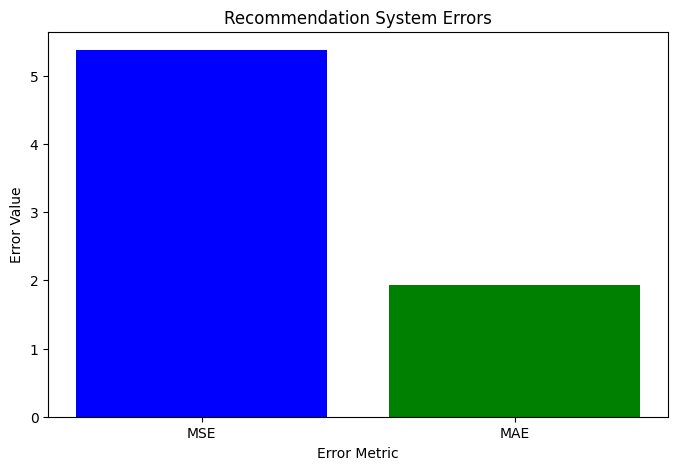

In [33]:
import matplotlib.pyplot as plt

# Create a bar plot for MSE and MAE
errors = [mse, mae]
error_labels = ['MSE', 'MAE']

plt.figure(figsize=(8, 5))
plt.bar(error_labels, errors, color=['blue', 'green'])
plt.title('Recommendation System Errors')
plt.xlabel('Error Metric')
plt.ylabel('Error Value')
plt.show()

###Neighbors are 5, and metric is euclidean

In [34]:
k = 5
nn_model_5_euc = NearestNeighbors(n_neighbors = k, metric = 'euclidean')
nn_model_5_euc.fit(train_data)

NearestNeighbors(metric='euclidean')

In [35]:
nearest_neighbors_indices_users_5_euc = nn_model_5_euc.kneighbors(test_data, return_distance=False)

In [36]:
predicted_ratings_5_euc = []

In [37]:
nearest_neighbors_indices_users_5_euc

array([[ 274, 1373, 1083, 1729, 2382],
       [2473, 2218,  886, 2216, 2003],
       [ 692, 2023, 1370, 2261,  415],
       ...,
       [1123, 2189, 1347, 2062, 2119],
       [2204,  274, 1083, 1373,  908],
       [1743, 1471, 1373, 2580, 1126]])

In [38]:
for user_index in test_data.index:
    user_ratings_5_euc = test_data.loc[user_index].values.reshape(1, -1)
    # Find nearest neighbors indices for the current user
    nearest_neighbors_indices_5_euc = nn_model_5_euc.kneighbors(user_ratings_5_euc, return_distance=False)

    # Get the ratings of the nearest neighbors for the current user
    nearest_neighbors_ratings_5_euc = train_data.iloc[nearest_neighbors_indices_5_euc[0]].values

    # Calculate the average rating for each movie
    average_ratings_5_euc = nearest_neighbors_ratings_5_euc.mean(axis=0)

    # Store the average ratings in the predicted_ratings list
    predicted_ratings_5_euc.append(average_ratings_5_euc)

In [39]:
predicted_ratings_df_5_euc = pd.DataFrame(predicted_ratings_5_euc, index=test_data.index, columns=test_data.columns)

In [40]:
predicted_ratings_df_5_euc

movieId,1,2,3,4,5,6,7,8,9,10,...,64508,64614,64620,64716,64839,64906,64957,64969,64997,65133
userId,,,,,,,,,,,,,,,,,,,,,
1789,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3222,2.7,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3270,0.5,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,3.6,0.0,1.2,0.0,1.0,1.6,2.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,2.2,0.0,0.4,0.0,0.0,1.2,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2742,2.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,2.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3385,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Initialize empty lists to store corresponding non-zero values
non_zero_test_values_5_euc = []
non_zero_predicted_values_5_euc = []

# Iterate through the test_data and predicted_ratings_df
for test_row, predicted_row in zip(test_data.values, predicted_ratings_df.values):
    for test_value, predicted_value in zip(test_row, predicted_row):
        if test_value != 0.0:
            non_zero_test_values_5_euc.append(test_value)
            non_zero_predicted_values_5_euc.append(predicted_value)

print(f'non_zero_test_values_5_euc: {non_zero_test_values_5_euc}\n')
print(f'non_zero_predicted_values_5_euc: {non_zero_predicted_values_5_euc}')

non_zero_test_values_5_euc: [5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 4.0, 5.0, 2.0, 3.0, 5.0, 5.0, 4.0, 5.0, 1.0, 5.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.5, 5.0, 2.5, 5.0, 2.0, 4.0, 2.0, 3.5, 3.5, 4.0, 2.0, 5.0, 4.0, 4.5, 5.0, 3.0, 3.5, 3.5, 4.5, 2.5, 3.0, 4.0, 3.5, 4.0, 2.0, 3.0, 3.5, 4.5, 3.5, 4.5, 3.5, 3.0, 4.0, 4.0, 4.0, 4.0, 3.5, 5.0, 3.5, 4.5, 3.5, 1.5, 3.5, 1.0, 3.5, 3.0, 4.0, 2.0, 3.5, 3.0, 4.0, 3.0, 4.0, 3.5, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 3.5, 3.0, 4.5, 4.0, 2.0, 3.5, 3.5, 4.5, 4.5, 5.0, 3.5, 4.0, 1.5, 3.5, 3.0, 1.0, 4.5, 4.0, 4.0, 4.5, 1.0, 4.0, 4.5, 4.0, 4.0, 3.5, 2.0, 4.0, 4.5, 4.0, 4.0, 3.0, 4.5, 4.5, 4.5, 3.5, 4.5, 4.0, 4.5, 4.0, 4.0, 4.0, 5.0, 4.0, 4.5, 3.0, 4.0, 3.0, 3.0, 3.5, 3.0, 3.5, 3.5, 4.0, 4.5, 4.0, 4.5, 4.5, 4.5, 4.0, 2.0, 4.5, 4.0, 4.5, 4.5, 4.0, 4.0, 4.5, 4.0, 4.0, 3.0, 4.0, 3.5, 3.0, 4.0, 4.0, 4.0, 4.0, 4.5, 3.5, 4.5, 2.5, 4.5, 4.0, 5.0, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 2.5, 4.0, 4.0, 4.5, 4.5, 3.5, 5.0, 3.0, 4.5, 4.0, 5.0, 5.0, 4.0, 4.5, 3.5, 4.5, 3.0, 3.0, 4.0, 4.0, 5

###Model accuracy and comparing where neighbors are 5 and metric is euclidean

In [42]:
mse_5_euc = mean_squared_error(non_zero_test_values_5_euc, non_zero_predicted_values_5_euc)

mae_5_euc = mean_absolute_error(non_zero_test_values_5_euc, non_zero_predicted_values_5_euc)

print(f'Mean Squared Error (MSE): {round(mse_5_euc,2)}')
print(f'Mean Absolute Error (MAE): {round(mae_5_euc,2)}')

Mean Squared Error (MSE): 5.37
Mean Absolute Error (MAE): 1.93
